In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#load the augmented image from directory and generate datasetc
batch_size= 32
img_height= 224
img_width= 224

train_datagen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)

test_datagen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(
        "./dataset/training/", 
        target_size= (img_width, img_height),  
        batch_size= batch_size,
        class_mode= "categorical")  


validation_generator= test_datagen.flow_from_directory(
        "./dataset/validation/",
        target_size= (img_width, img_height),
        batch_size= batch_size,
        class_mode="categorical")

Found 508 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


Tensor shape with batch 32:  (32, 224, 224, 3)


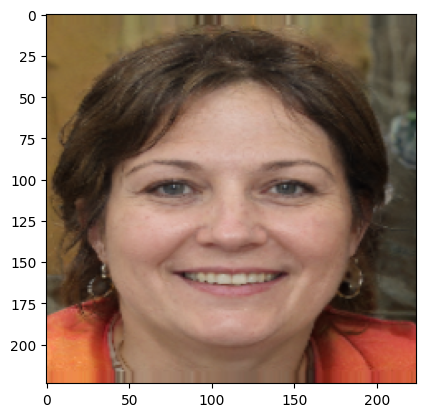

In [4]:
#Tensor shape of images generated by ImageGenerator
print("Tensor shape with batch 32: ", train_generator[0][0].shape)
#print(train_generator.shape)
image= train_generator[0][0][0]
plt.imshow(image)

Tensor shape with batch 32:  (32, 224, 224, 3)


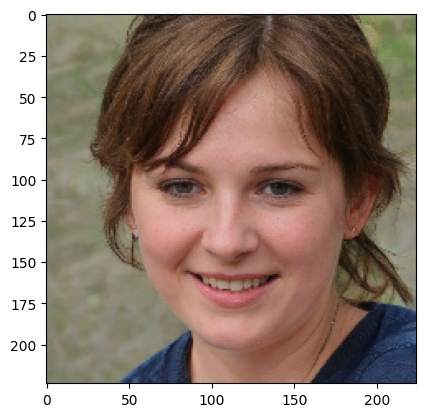

In [5]:
#Tensor shape of images generated by ImageGenerator
print("Tensor shape with batch 32: ", validation_generator[0][0].shape)

image = validation_generator[0][0][0]
plt.imshow(image)

In [6]:
labels= (train_generator.class_indices)
labels= dict((v,k) for k,v in labels.items())
print(labels)

num_classes= len(labels)

{0: 'NoTic', 1: 'Tic'}


In [7]:
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    
for layer in resnet.layers:
    layer.trainable = False

# Create a new model with a single dense layer
x = resnet.output
x= GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=resnet.input, outputs=output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
history = model.fit(train_generator, validation_data=validation_generator, epochs= 100, verbose=1, callbacks= early_stop)

Epoch 1/100
12/16 [=====================>........] - ETA: 24s - loss: 0.8364 - accuracy: 0.5625

In [ ]:
model.save("try.h5")
print("Saved model to disk")

In [ ]:
#Final evaluation of the model
scores= model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Extract the accuracy and loss from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get the number of epochs
epochs = range(len(acc))

# Plot the training and validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(epochs, acc, "r", label="Training acc")
axs[0].plot(epochs, val_acc, "b", label="Validation acc")
axs[0].set_title("Training and validation accuracy")
axs[0].legend()

axs[1].plot(epochs, loss, "r", label="Training loss")
axs[1].plot(epochs, val_loss, "b", label="Validation loss")
axs[1].set_title("Training and validation loss")
axs[1].legend()
plt.show()

In [ ]:
#Load the previously saved model eg. flowers_model.h5
model= models.Sequential()

model= models.load_model("./try.h5")

#The label that classifing
labels= {0: "NoTic", 1: "Tic"}
testimage_path= "./dataset/testing/Tic4.png"

img= tf.keras.preprocessing.image.load_img(testimage_path, target_size=(img_height, img_width))

img_array= tf.keras.preprocessing.image.img_to_array(img)
img_array= tf.expand_dims(img_array, 0)
print(img_array.shape)

#CLassify the input image data
predictions= model.predict(img_array)

#Convert into final result using softmax
score= tf.nn.softmax(predictions)

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(labels[np.argmax(score)], 100 * np.max(score)))